# asterism - 2 Train NN on dataframe

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product

import corner
import matplotlib.pyplot as plt

import keras
from keras import layers
import sklearn
from sklearn.decomposition import PCA

2024-06-26 18:00:49.078376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 18:00:49.078407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 18:00:49.079532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-26 18:00:49.085141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 18:00:49.689179: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf

In [3]:
## GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

print("Current GPU usage:\n", f" - GPU0: {gpu0usage} B\n")

Current GPU usage:
  - GPU0: 0 B



2024-06-26 18:00:50.532506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-26 18:00:50.569797: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-26 18:00:50.570097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# Define user inputs
gridpath = "./dfs/"
gridfile = "chiara_AS09_NN.csv"
figpath = "./figs/"

inputs = [
    "massini",
    "zini",
    "yini",
    "alphaMLT",
    "age",
]

classical_outputs = ["radPhot", "LPhot", "zsur"]
nmin = 1
nmax = 15

fractrain = 0.95
test_size = 0.05

seed = 42

model_name = "simple_network"
n_dense_layers = 4  # number of dense layers
dense_layer_units = 64  # neurons per dense layer

### Data frame initialisation

#### Make the HDF5-file into a csv file for an easy dataframe
That is done in `1 Convert grid to dataframe`.

In [5]:
grid = os.path.join(gridpath, gridfile)
assert os.path.exists(grid)

In [6]:
grid = pd.read_csv(grid)

#### Define inputs and outputs

In [7]:
astero_outputs = [f"nu_0_{i+1}" for i in range(nmin, nmax)]  # 10 modes for now

outputs = classical_outputs + astero_outputs

#### Scale all dimensions

In [8]:
def norm(df: pd.DataFrame) -> pd.DataFrame:
    return (df - df.min()) / (df.max() - df.min())


def unnorm(df_norm: pd.DataFrame, df_min: float, df_max: float) -> pd.DataFrame:
    df_unnorm = (df_norm * (df_max - df_min)) + df_min
    return df_unnorm

In [9]:
df = grid[inputs + outputs]
df_norm = norm(df)

df_norm.describe()

,massini,zini,yini,alphaMLT,age,radPhot,LPhot,zsur,nu_0_2,nu_0_3,...,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,nu_0_13,nu_0_14,nu_0_15
count,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,...,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06
mean,5.320517e-01,1.169785e-01,4.801320e-01,5.207879e-01,2.894701e-01,4.971213e-01,2.481507e-01,1.171824e-01,1.077112e-01,1.200469e-01,...,1.188594e-01,1.185161e-01,1.183595e-01,1.189114e-01,1.194570e-01,1.198425e-01,1.202142e-01,1.206998e-01,1.210956e-01,1.212752e-01
std,2.741396e-01,1.503168e-01,2.866208e-01,2.874298e-01,2.407603e-01,2.467036e-01,1.738870e-01,1.504480e-01,1.598827e-01,1.736449e-01,...,1.747065e-01,1.739518e-01,1.735345e-01,1.736557e-01,1.737441e-01,1.737238e-01,1.738433e-01,1.742601e-01,1.746516e-01,1.747926e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.050000e-01,1.490123e-02,2.313656e-01,2.751358e-01,1.004077e-01,2.980220e-01,1.053661e-01,1.492283e-02,1.705047e-02,1.969460e-02,...,1.778337e-02,1.807635e-02,1.810694e-02,1.848769e-02,1.880892e-02,1.898436e-02,1.912027e-02,1.925980e-02,1.937595e-02,1.946248e-02
50%,5.362500e-01,5.506925e-02,4.703010e-01,5.304316e-01,2.083946e-01,5.097711e-01,2.169322e-01,5.511907e-02,4.666825e-02,5.289470e-02,...,5.011713e-02,5.007471e-02,5.028489e-02,5.085777e-02,5.146385e-02,5.189566e-02,5.216918e-02,5.241651e-02,5.260663e-02,5.270680e-02
75%,7.675000e-01,1.620700e-01,7.242537e-01,7.715646e-01,4.200869e-01,7.015910e-01,3.606867e-01,1.627696e-01,1.229736e-01,1.382720e-01,...,1.363420e-01,1.356656e-01,1.354173e-01,1.363623e-01,1.372522e-01,1.379930e-01,1.387353e-01,1.394955e-01,1.400151e-01,1.401755e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Split into training/validation/test data sets

In [10]:
df_train = df_norm.sample(frac=fractrain, random_state=seed)
df_test = df_norm.drop(df_train.index)

(
    df_train_inputs,
    df_val_inputs,
    df_train_outputs,
    df_val_outputs,
) = sklearn.model_selection.train_test_split(
    df_train[inputs], df_train[outputs], test_size=test_size, random_state=seed
)

print("Training set: ", len(df_train_inputs))
print("Validation set: ", len(df_val_inputs))
print("Test set: ", len(df_test))

Training set:  6754081
Validation set:  355478
Test set:  374187


### Set-up model

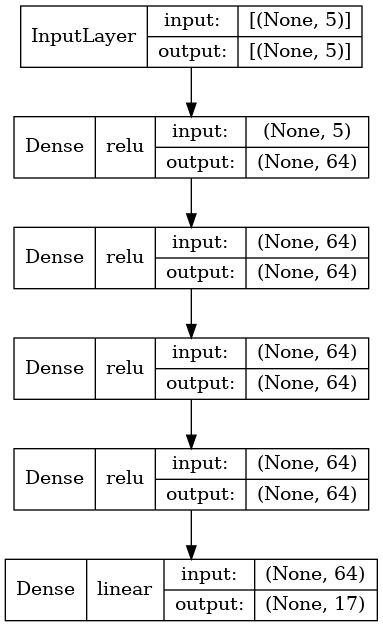

In [11]:
nn_input = keras.Input(shape=(len(inputs),))

for n_dense_layer in range(n_dense_layers):
    if n_dense_layer == 0:
        dense_layer = layers.Dense(dense_layer_units, activation="relu")(nn_input)
    else:
        dense_layer = layers.Dense(dense_layer_units, activation="relu")(dense_layer)

nn_output = layers.Dense(len(outputs), activation="linear")(dense_layer)

model = keras.Model(inputs=nn_input, outputs=nn_output, name=model_name)

if not os.path.exists(figpath):
    os.makedirs(figpath)
figname = os.path.join(figpath, f"{model_name}.png")

keras.utils.plot_model(
    model,
    figname,
    show_layer_activations=True,
    show_shapes=True,
    show_layer_names=False,
)

### Compile and start training

In [12]:
model.compile(loss="MSE", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model.fit(
    df_train_inputs,
    df_train_outputs,
    validation_data=(df_val_inputs, df_val_outputs),
    batch_size=4096,
    verbose=1,
    epochs=10,
    shuffle=True,
)

Epoch 1/10


2024-06-26 18:01:15.243166: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-26 18:01:15.566487: I external/local_xla/xla/service/service.cc:168] XLA service 0x613daa8b7f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-26 18:01:15.566519: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-06-26 18:01:15.575406: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-26 18:01:15.597116: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1719421275.673944   23235 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1649/1649 [==============================] - 7s 3ms/step - loss: 0.0275 - val_loss: 0.0238
Epoch 2/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0200 - val_loss: 0.0184
Epoch 3/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0193 - val_loss: 0.0175
Epoch 4/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 5/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0155 - val_loss: 0.0141
Epoch 6/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0146 - val_loss: 0.0176
Epoch 7/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0144 - val_loss: 0.0123
Epoch 8/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0145 - val_loss: 0.0158
Epoch 9/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0146 - val_loss: 0.0122
Epoch 10/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0136 - val_los

## Have a look at the predictions

In [13]:
preds_norm = model(np.array(df_test[inputs]))

df_preds_norm = pd.DataFrame(preds_norm, columns=outputs)
df_preds_unnorm = unnorm(df_preds_norm, df[outputs].min(), df[outputs].max())

df_test_unnorm = unnorm(df_test, df.min(), df.max())

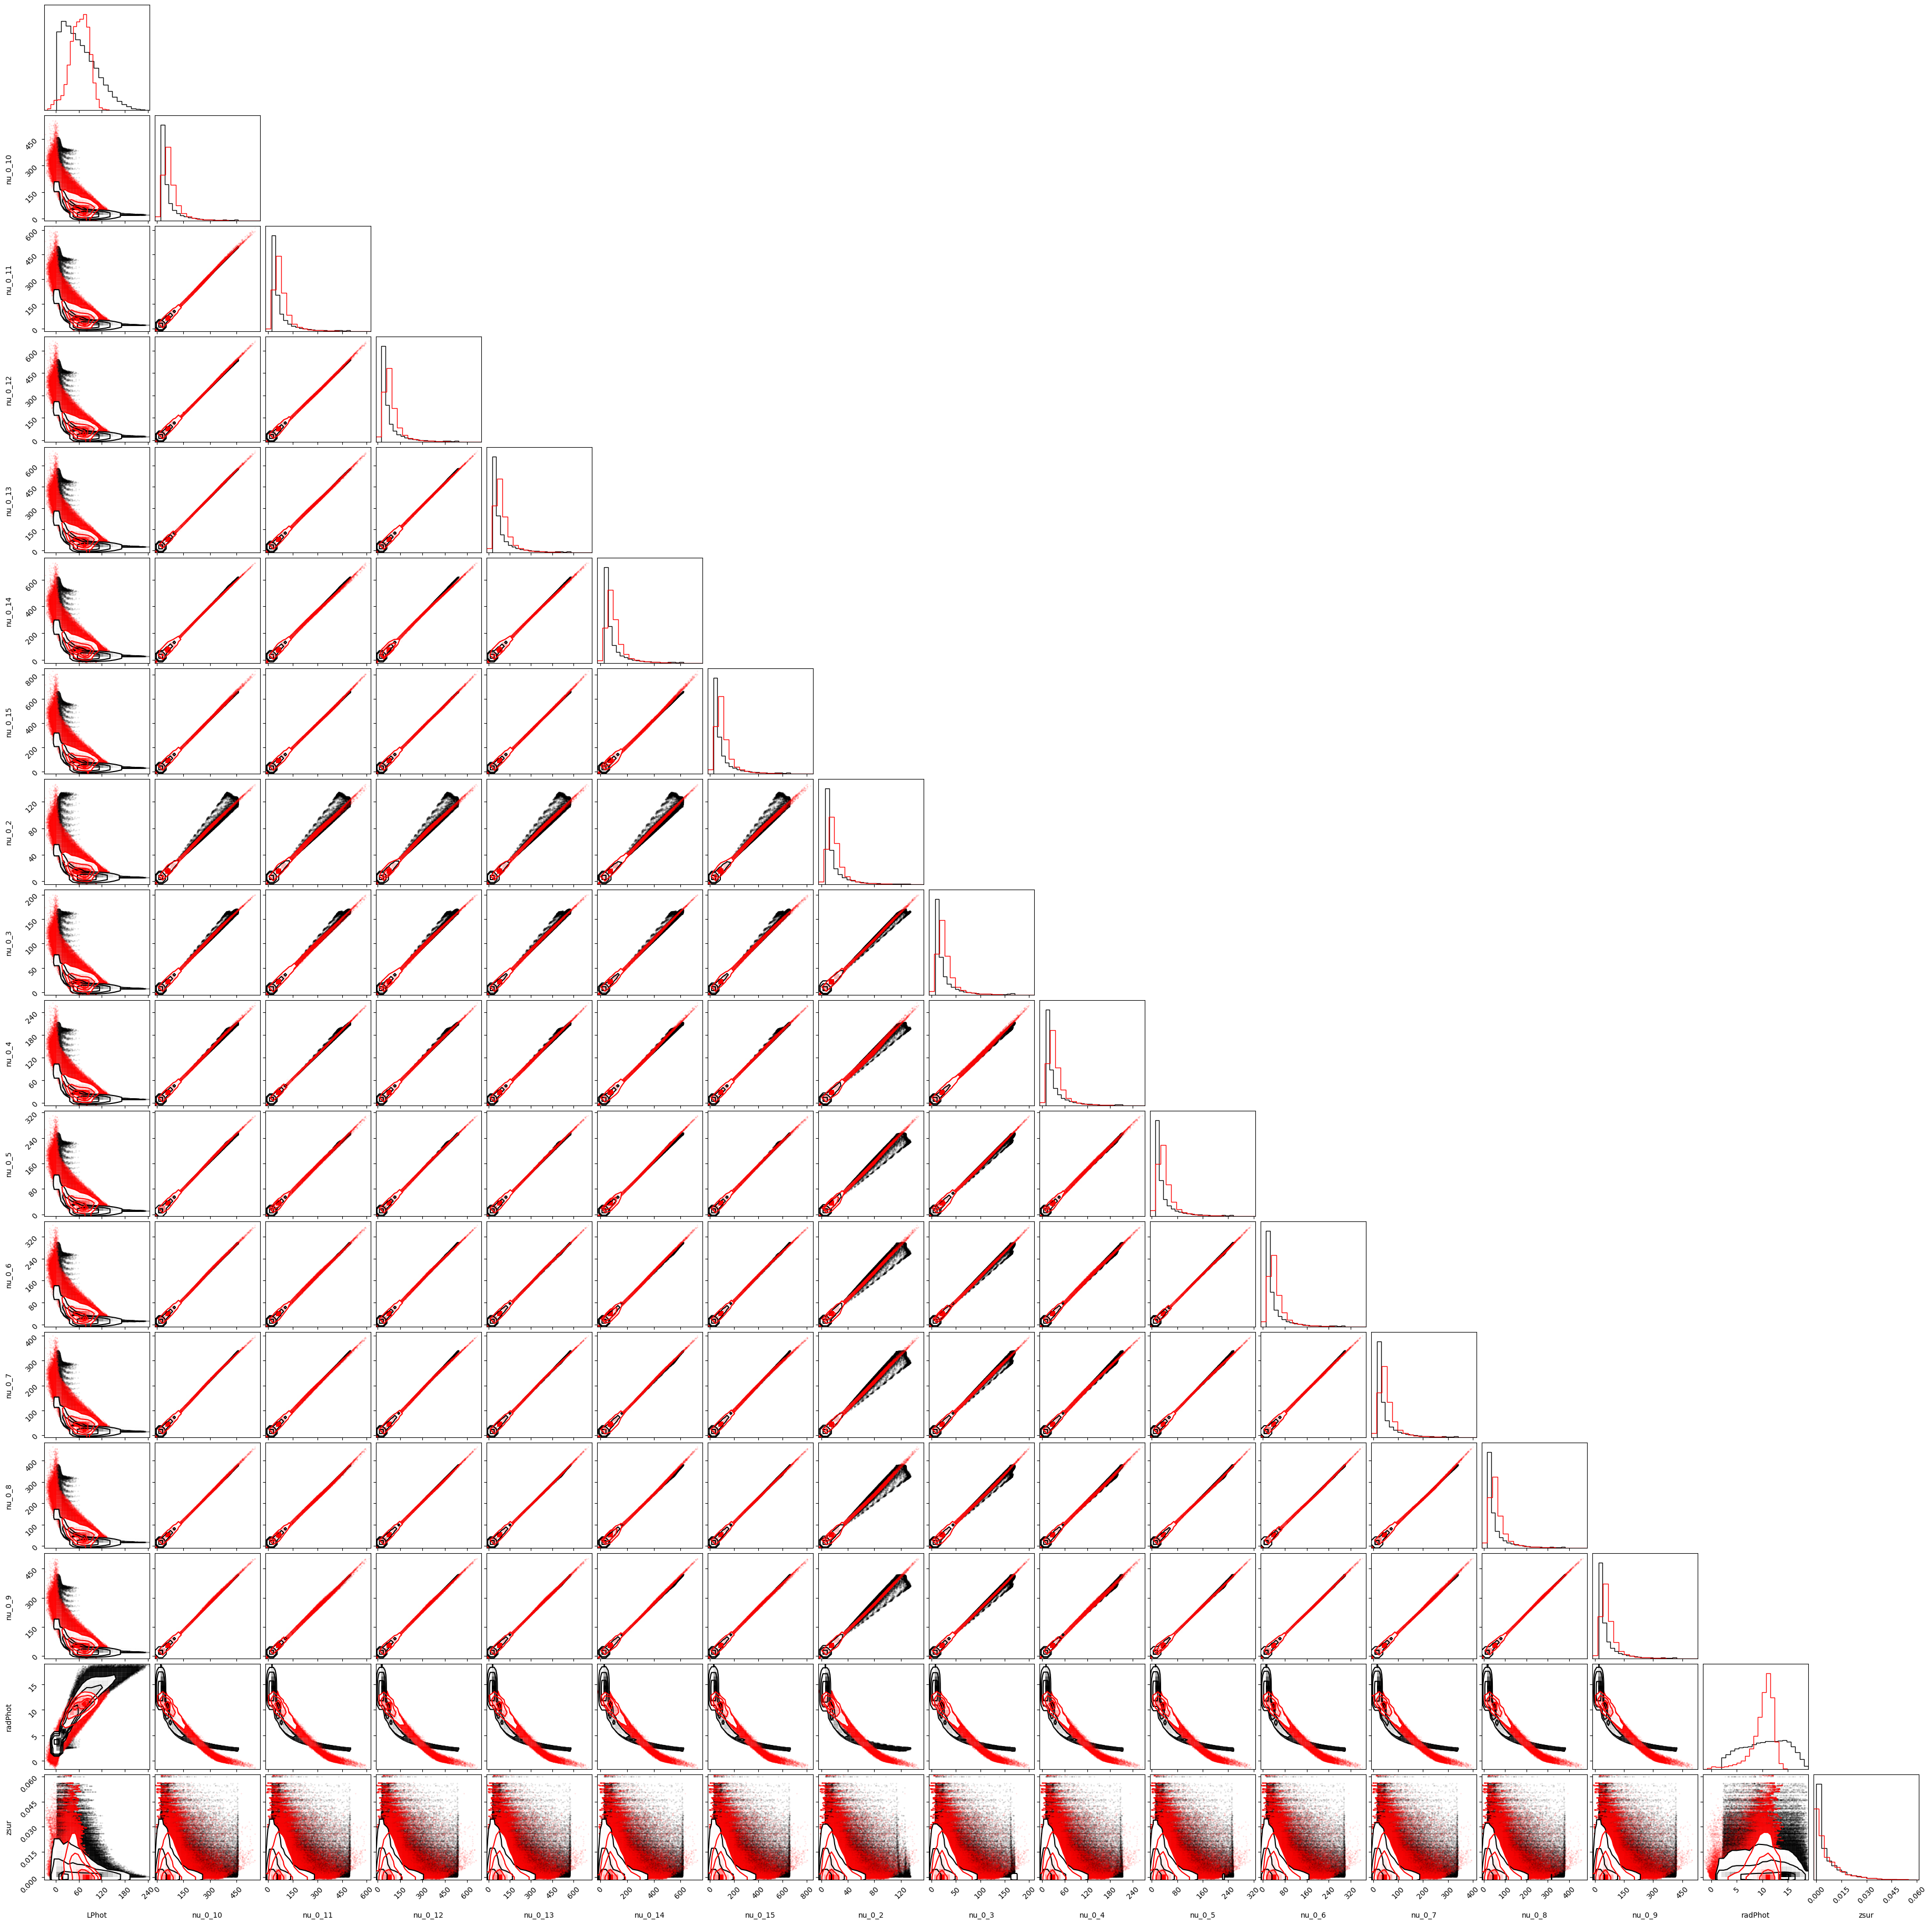

Error in callback <function _draw_all_if_interactive at 0x79a6564c2b90> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79a586bf6c20> (for post_execute):


KeyboardInterrupt: 

In [14]:
figure = corner.corner(df_test_unnorm[outputs])
corner.corner(df_preds_unnorm, color="red", fig=figure)